# Denpasar Weather Forecasting with TensorFlow

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import io
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import statsmodels.api as sm
import seaborn as sns


mpl.rcParams['figure.figsize'] = (12, 5)
mpl.rcParams['axes.grid'] = False

## The weather dataset

This dataset is collected from https://openweathermaps.org pointed in Denpasar, Bali. The dataset contains hourly weather data from January 1st 1990 until January 7th 2020. Originally there are 32 features, although has been reduced the unnecessary features to  11 features as shown below. You can access this data at https://www.kaggle.com/cornflake15/denpasarbalihistoricalweatherdata

In [2]:
usecols = ['dt_iso', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
           'clouds_all', 'weather_main', 'weather_description']
df = pd.read_csv(r"D:\Bangkit\Terbaroe\openweatherdata-denpasar-1990-2020v0.1.csv", parse_dates=True, index_col='dt_iso', usecols=usecols)
df.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description
dt_iso,,,,,,,,,,
1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86,1.36,225,98,Rain,light rain
1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84,2.09,247,91,Rain,light rain
1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84,2.44,262,94,Rain,light rain
1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82,2.29,271,94,Rain,light rain
1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82,1.71,274,76,Clouds,broken clouds


In [3]:
df.shape

(264924, 10)

**Data Split Function**

In [4]:
# Split the data by percentage
def num_data_train(percentage, data_length):
    num_data = percentage / 100 * data_length
    return int(num_data)

From this section, the code is adapted from **Time Series Tensorflow Tutorial**.

Source: https://www.tensorflow.org/tutorials/structured_data/time_series

## Forecast a univariate time series

In this part, we tested how ML method works at time series data. We conducted simple forecasting on single feature (temperature).

**Split the data**

In [5]:
TRAIN_SPLIT = num_data_train(70, df.shape[0]) # Split 70% of the data for training
tf.random.set_seed(13) # Setting seed to ensure reproducibility
print('Length of Data Train: {}'.format(TRAIN_SPLIT))

Length of Data Train: 185446


In [6]:
# Train a model using a single feature (temperature)
dt_temp = df['temp']
dt_temp.tail()

dt_iso
2020-01-07 19:00:00    27.0
2020-01-07 20:00:00    27.0
2020-01-07 21:00:00    28.0
2020-01-07 22:00:00    28.0
2020-01-07 23:00:00    28.0
Name: temp, dtype: float64

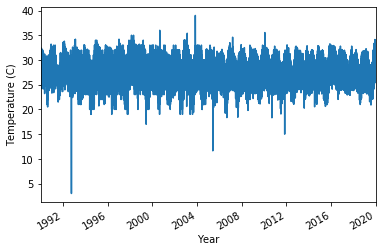

In [7]:
dt_temp.plot(subplots=True)
plt.xlabel('Year')
plt.ylabel('Temperature (C)')
plt.show()

In [8]:
# Convert the dataframe into numpy array
array_temp = dt_temp.values
print(array_temp[:10]) # Print 10 elements for checking

[25.82 26.2  26.45 26.8  27.04 27.23 27.32 27.29 27.34 27.23]


In [9]:
# Scaling the features
array_temp_mean = array_temp[:TRAIN_SPLIT].mean()
array_temp_std = array_temp[:TRAIN_SPLIT].std()
print('Training Data Mean: {}'.format(array_temp_mean))
print('\nTraining Data Std.Dev: {}'.format(array_temp_std))

Training Data Mean: 27.1836268239811

Training Data Std.Dev: 1.9980058874922433


In [10]:
# Standardize the data
array_temp = (array_temp - array_temp_mean) / array_temp_std
print(array_temp)

[-0.6824939  -0.49230427 -0.36717951 ...  0.40859398  0.40859398
  0.40859398]


In [11]:
# create a function that return the time windows for the model to train on
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In this part, the model will be given the last **`n`** recorded temperature observation, and needs to learn to predict the temperature at the next **`m`** time step.

In [12]:
# Create the univariate model
data_past_history = 30 # number of last recorded data (n)
data_future_target = 0 # number of time step (m)

x_train, y_train = univariate_data(array_temp, 0, TRAIN_SPLIT, data_past_history, data_future_target)
x_val, y_val = univariate_data(array_temp, TRAIN_SPLIT, None, data_past_history, data_future_target)

print('Single window of past history:')
print(x_train[0])
print('\n Target temperature to predict:')
print(y_train[0])

Single window of past history:
[[-0.6824939 ]
 [-0.49230427]
 [-0.36717951]
 [-0.19200485]
 [-0.07188509]
 [ 0.02320973]
 [ 0.06825464]
 [ 0.05323967]
 [ 0.07826462]
 [ 0.02320973]
 [ 0.10829456]
 [ 0.07325963]
 [-0.19700984]
 [-0.44725935]
 [-0.56237413]
 [-0.63244399]
 [-0.63744898]
 [-0.65246396]
 [-0.69750887]
 [-0.8326436 ]
 [-1.01782824]
 [-1.0428532 ]
 [-1.03284321]
 [-1.07788813]
 [-1.01782824]
 [-0.99280329]
 [-0.96777834]
 [-0.8326436 ]
 [-0.85766856]
 [-0.75256376]]

 Target temperature to predict:
-0.8076186532194914


Now that the data has been created, The information given to the network is given in blue, and it must predict the value at the red cross.

In [13]:
def create_time_steps(length):
    return list(range(-length, 0))

In [14]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
       
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\ACER\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

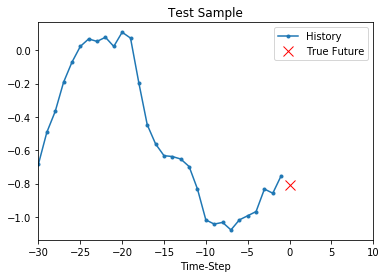

In [15]:
show_plot([x_train[0], y_train[0]], 0, 'Test Sample')

**We compared two models, first is simple `sequential` model with 2 layers and second is simple `LSTM` model with 1 layer.**

In [16]:
from tensorflow.keras import layers
tf.keras.backend.clear_session()  # For easy reset of notebook state.

# Normal Sequential model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=x_train.shape[-2:]), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compare with simple LSTM Model, according to several sources LSTM is suitable for modeling time series data
model_2 = tf.keras.models.Sequential(
    [tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]), tf.keras.layers.Dense(1)]
)
model_1.summary()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 16)            32        
_________________________________________________________________
dense_1 (Dense)              (None, 30, 16)            272       
_________________________________________________________________
dense_2 (Dense)              (None, 30, 1)             17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 

In [17]:
model_1.compile(optimizer='adam', loss='mae')
model_2.compile(optimizer='adam', loss='mae')

**Further reading:**
    
    1. https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
    2. https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list/45944225
    3. https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [18]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

datatrain = tf.data.Dataset.from_tensor_slices((x_train, y_train))
datatrain = datatrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

dataval = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataval = dataval.batch(BATCH_SIZE).repeat()

In [19]:
EPOCHS = 10
STEPS_PER_EPOCH = 200 # number of time steps
VALIDATION_STEPS = 50

# Train the model
model_1_history = model_1.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)
model_2_history = model_2.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 11ms/step - loss: 0.6002 - val_loss: 0.7154
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.8129 - val_loss: 0.7022
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7974 - val_loss: 0.7008
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6201 - val_loss: 0.7518
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7549 - val_loss: 0.7077
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7994 - val_loss: 0.7036
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7809 - val_loss: 0.7024
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5791 - val_loss: 0.7200
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8123 - val_loss: 0.7033
Epoch 10/10
200/200 [==============================] - 1

In [20]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

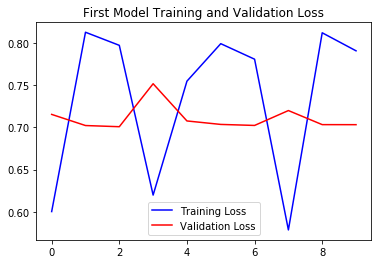

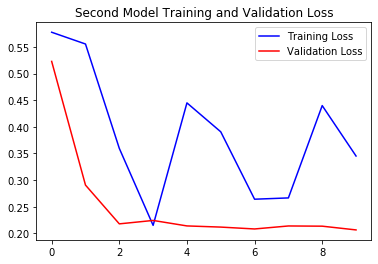

In [21]:
plot_train_history(model_1_history, 'First Model Training and Validation Loss')
plot_train_history(model_2_history, 'Second Model Training and Validation Loss')

**The graph above indicates that the model performance was not really good because we only use single feature (temperature)**
First model is not really clear whether it is overfit or underfit, but the second model clealy underfit. Second model need hyperparameter tuning or because it used only single feature.

In the next section we will use multi-feature/multivariate forecasting.

Further readings:
    1. https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss
    2. https://stackoverflow.com/questions/48226086/training-loss-and-validation-loss-in-deep-learning

# Multivariate Forecasting

In this part we decided to use multivariate forecasting to see how the LSTM method performs. We use five features that has the most important parts in forecasting weather, i.e, **average air temperature** (`temp`), **minimum air temperature** (`temp_min`), **maximum air temperature** (`temp_max`), **air pressure** (`pressure`), and **air humidity** (`humidity`).

In [22]:
# df_multivariate = df.drop(['weather_main', 'weather_description'], axis=1)
df_multivariate = df[['temp', 'temp_min', 'temp_max', 'pressure', 'humidity']]
df_multivariate.head()

,temp,temp_min,temp_max,pressure,humidity
dt_iso,,,,,
1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86
1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84
1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84
1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82
1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82


Analyze the features correlation with correlation matrix

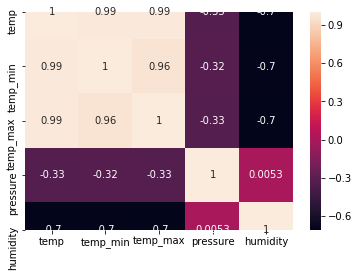

In [23]:
import seaborn as sns

sns.heatmap(df_multivariate.corr(), annot=True)
plt.show()

We didn't used 2020 data because there was contain only seven days of data therefore we used data from January 1st 1990 until December 31st 2019.

In [24]:
# Don't use data in 2020
df_multivariate = df_multivariate.loc['1990':'2019']
df_multivariate.tail()

,temp,temp_min,temp_max,pressure,humidity
dt_iso,,,,,
2019-12-31 19:00:00,27.08,27.0,27.2,1009.0,88
2019-12-31 20:00:00,26.64,26.0,27.0,1009.0,94
2019-12-31 21:00:00,26.00,26.0,26.0,1009.0,94
2019-12-31 22:00:00,26.00,26.0,26.0,1009.0,94
2019-12-31 23:00:00,27.00,27.0,27.0,1010.0,88


In [25]:
# Convert the dataframe to numpy array
# df_multivariate = df_multivariate.drop('date', axis=1)
dt_multivariate = df_multivariate.values
print('Number of dataset: {}'.format(len(df_multivariate)))
print('10 samples of data: \n{}'.format(dt_multivariate[:10]))

Number of dataset: 264756
10 samples of data: 
[[  25.82   25.82   25.82 1010.     86.  ]
 [  26.2    26.2    26.2  1011.     84.  ]
 [  26.45   26.45   26.45 1011.     84.  ]
 [  26.8    26.8    26.8  1011.     82.  ]
 [  27.04   27.04   27.04 1010.     82.  ]
 [  27.23   27.23   27.23 1009.     82.  ]
 [  27.32   27.32   27.32 1008.     82.  ]
 [  27.29   27.29   27.29 1008.     82.  ]
 [  27.34   27.34   27.34 1007.     81.  ]
 [  27.23   27.23   27.23 1007.     82.  ]]


In [26]:
#Normalizing the data using StandardScaler from sklearn, instead of using the conventional calculation like the above before
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dt_multivariate = sc.fit_transform(dt_multivariate)
print('Normalized data:')
print(dt_multivariate[10])
print(dt_multivariate.shape)

Normalized data:
[ 0.06489342  0.1281178   0.00158411 -0.88977112  0.01811545]
(264756, 5)


## 1. Time Series Modelling

### Making Time Series Stationary
Here is a step to make a time series stationary

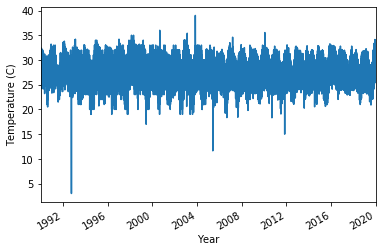

In [27]:
dt_temp.plot()
plt.xlabel('Year')
plt.ylabel('Temperature (C)')
plt.show()

**1. Take a Difference to Fix Non-Stationary Dataset**

In [28]:
#Using the Temperature Feature only
usecols = ['dt_iso', 'temp']
dt_temp1 = pd.read_csv(r"D:\Bangkit\dataset\openweatherdata-denpasar-1990-2020v0.1.csv", parse_dates=True, index_col='dt_iso', usecols=usecols)
dt_temp1.head()

,temp
dt_iso,
1990-01-01 00:00:00,25.82
1990-01-01 01:00:00,26.20
1990-01-01 02:00:00,26.45
1990-01-01 03:00:00,26.80
1990-01-01 04:00:00,27.04


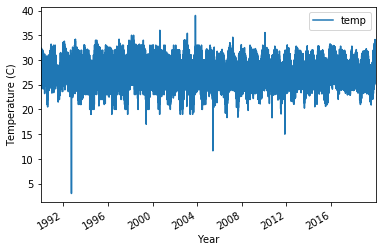

In [29]:
#don't use data in 2020
dt_temp1['1990':'2019'].plot()
plt.xlabel('Year')
plt.ylabel('Temperature (C)')
plt.show()

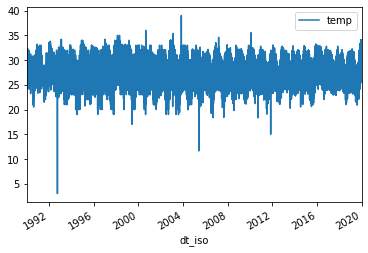

In [30]:
dt_temp1.plot()

In [31]:
#1. yt = yt - y(t-1)
dt_temp1 = dt_temp1 - dt_temp1 .shift(1)

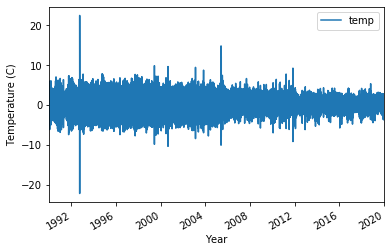

In [32]:
dt_temp1.plot()
plt.xlabel('Year')
plt.ylabel('Temperature (C)')
plt.show()

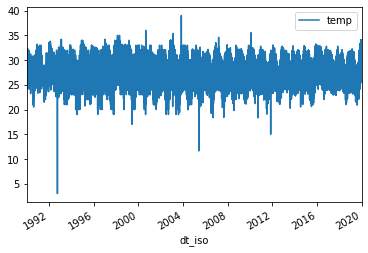

In [33]:
#2. df.diff
usecols = ['dt_iso', 'temp']
dt_temp2 = pd.read_csv(r"D:\Bangkit\dataset\openweatherdata-denpasar-1990-2020v0.1.csv", parse_dates=True, index_col='dt_iso', usecols=usecols)
dt_temp2.plot()

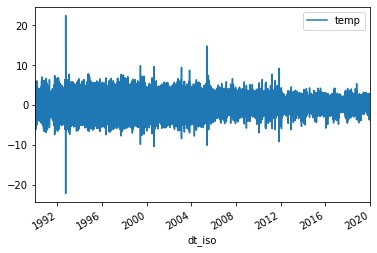

In [34]:
df_diff = dt_temp2.diff(periods=1)
df_diff.plot()

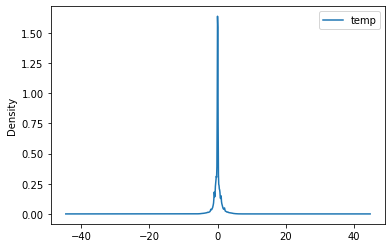

In [35]:
df_diff = dt_temp2.diff(periods=1)
df_diff.plot(kind='kde')

**OUR DATASET IS NOW STATIONARY YEAY!**

### DECOMPOSE OUR DATASET
Here is a step to make a time series stationary

In [36]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
dt_temp1.head()

,temp
dt_iso,
1990-01-01 00:00:00,NaN
1990-01-01 01:00:00,0.38
1990-01-01 02:00:00,0.25
1990-01-01 03:00:00,0.35
1990-01-01 04:00:00,0.24


In [38]:
dt_temp1[1:]

,temp
dt_iso,
1990-01-01 01:00:00,0.38
1990-01-01 02:00:00,0.25
1990-01-01 03:00:00,0.35
1990-01-01 04:00:00,0.24
1990-01-01 05:00:00,0.19
...,...
2020-01-07 19:00:00,0.00
2020-01-07 20:00:00,0.00
2020-01-07 21:00:00,1.00


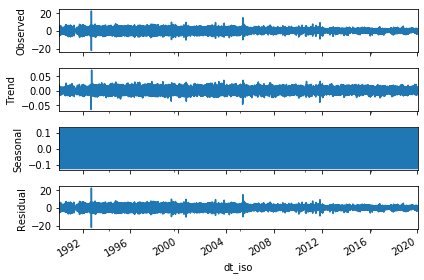

In [39]:
#Decomposition plot
decomposition = sm.tsa.seasonal_decompose(dt_temp1[1: ], model='additive', freq=365)
fig = decomposition.plot()

## 2. Exploration Data Analysis

In [40]:
import numpy as pd
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale

import sklearn.metrics as sn
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report

In [41]:
#Define working directory
os.chdir(r"D:\Bangkit\dataset")

In [42]:
#Import Dataset
usecols = ['dt_iso', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
           'clouds_all', 'weather_main', 'weather_description']
df = pd.read_csv(r"D:\Bangkit\Terbaroe\openweatherdata-denpasar-1990-2020v0.1.csv", parse_dates=True, usecols=usecols)
df.head()

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description
0,1/1/1990 0:00,25.82,25.82,25.82,1010.0,86,1.36,225,98,Rain,light rain
1,1/1/1990 1:00,26.20,26.20,26.20,1011.0,84,2.09,247,91,Rain,light rain
2,1/1/1990 2:00,26.45,26.45,26.45,1011.0,84,2.44,262,94,Rain,light rain
3,1/1/1990 3:00,26.80,26.80,26.80,1011.0,82,2.29,271,94,Rain,light rain
4,1/1/1990 4:00,27.04,27.04,27.04,1010.0,82,1.71,274,76,Clouds,broken clouds


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 11 columns):
dt_iso                 264924 non-null object
temp                   264924 non-null float64
temp_min               264924 non-null float64
temp_max               264924 non-null float64
pressure               264924 non-null float64
humidity               264924 non-null int64
wind_speed             264924 non-null float64
wind_deg               264924 non-null int64
clouds_all             264924 non-null int64
weather_main           264924 non-null object
weather_description    264924 non-null object
dtypes: float64(5), int64(3), object(3)
memory usage: 22.2+ MB


In [44]:
#drop duplicates rows
df = df.drop_duplicates(keep='first')

In [45]:
#shape of the data
df.shape

(264893, 11)

In [46]:
#Data statistic
df.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all
count,264893.000000,264893.000000,264893.000000,264893.000000,264893.000000,264893.000000,264893.000000,264893.000000
mean,27.273318,27.147936,27.397469,1010.033032,80.844741,3.612410,158.190873,38.478140
std,1.962629,1.973281,1.989230,2.286535,8.720337,1.909558,84.991672,24.929806
min,3.000000,2.000000,3.000000,998.400000,14.000000,0.010000,0.000000,0.000000
25%,25.940000,25.820000,26.000000,1008.400000,74.000000,2.100000,106.000000,20.000000
50%,27.000000,27.000000,27.000000,1010.200000,83.000000,3.600000,120.000000,26.000000
75%,28.600000,28.400000,29.000000,1011.900000,88.000000,4.710000,250.000000,40.000000
max,39.000000,39.000000,39.800000,1023.200000,100.000000,31.900000,360.000000,100.000000


In [47]:
#sorting w.r.t a vaiable
df_sort = df.sort_values(by='temp', ascending=False).head()
df_sort.head()

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description
121777,11/4/2003 4:00,39.00,39.0,39.0,1010.8,40,3.60,100,20,Clouds,few clouds
93659,8/26/2000 16:00,36.00,36.0,36.0,1011.9,47,2.60,110,20,Clouds,few clouds
176874,1/28/2010 5:00,35.54,29.0,39.8,1009.1,79,5.70,250,20,Clouds,few clouds
176876,1/28/2010 7:00,35.54,29.0,39.8,1008.1,79,6.20,260,75,Clouds,broken clouds
115411,2/12/2003 20:00,35.40,35.4,35.4,1007.1,52,1.13,125,20,Clouds,few clouds


(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 7.0000e+00, 3.4000e+01, 7.4000e+01, 7.7000e+01,
        3.4100e+02, 8.4100e+02, 1.7980e+03, 2.2160e+03, 9.2970e+03,
        2.8062e+04, 3.7486e+04, 3.0055e+04, 4.4135e+04, 3.4936e+04,
        1.6749e+04, 2.0413e+04, 1.8538e+04, 1.2715e+04, 3.4840e+03,
        2.7840e+03, 6.9400e+02, 7.4000e+01, 6.6000e+01, 4.0000e+00,
        4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 3.  ,  3.72,  4.44,  5.16,  5.88,  6.6 ,  7.32,  8.04,  8.76,
         9.48, 10.2 , 10.92, 11.64, 12.36, 13.08, 13.8 , 14.52, 15.24,
        15.96, 16.68, 17.4 , 18.12, 18.84, 19.56, 20.28, 21.  , 21.72,
        22.44, 23.16, 23.88, 24.6 , 25.32, 26.04, 26.76, 27.48, 28.2 ,
        28.92, 29.64, 30.36, 31.08

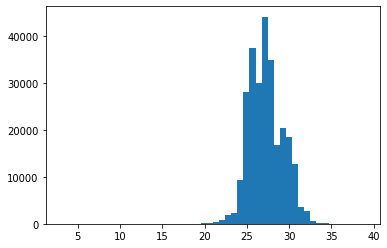

In [48]:
#Histogram continuous numerical variable
num_bins = 50
plt.hist(df['temp'], num_bins)

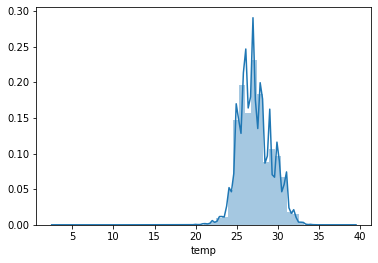

In [49]:
#pdfs
sns.distplot(df['temp'], bins=50)

In [50]:
#count by category - cross tabulate
make_dist = df.groupby('temp').size()

In [51]:
make_dist

temp
3.00     2
11.63    1
14.85    1
15.00    1
16.77    1
        ..
35.00    3
35.40    1
35.54    2
36.00    1
39.00    1
Length: 1221, dtype: int64

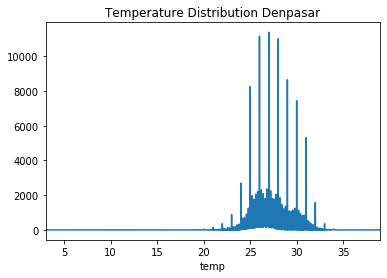

In [52]:
#distribution of categorical variable
make_dist.plot(title='Temperature Distribution Denpasar')

In [53]:
#select all numerical values
df_num = df.select_dtypes(include=['float64', 'int64'])
df_num.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all
0,25.82,25.82,25.82,1010.0,86,1.36,225,98
1,26.20,26.20,26.20,1011.0,84,2.09,247,91
2,26.45,26.45,26.45,1011.0,84,2.44,262,94
3,26.80,26.80,26.80,1011.0,82,2.29,271,94
4,27.04,27.04,27.04,1010.0,82,1.71,274,76


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABB5083148>,
      dtype=object)

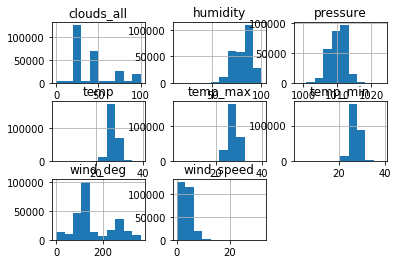

In [54]:
df_num.hist()

In [55]:
#correlation with the variable of interest
df_corr = df_num.corr()['temp'][:1]

In [56]:
df_corr

temp    1.0
Name: temp, dtype: float64

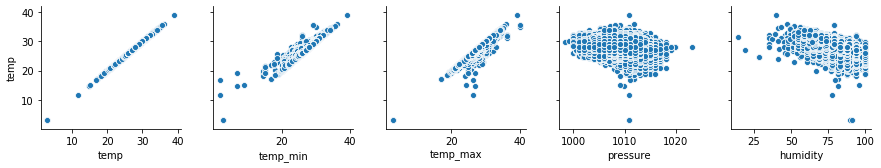

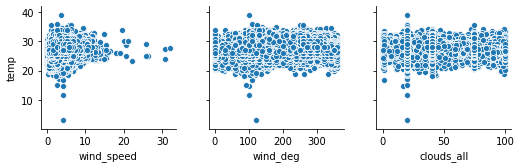

In [57]:
#correlation plots using 'pairplot'
for i in range(0, len(df_num.columns),5):
    sns.pairplot(df_num, y_vars=['temp'], x_vars=df_num.columns[i:i+5])

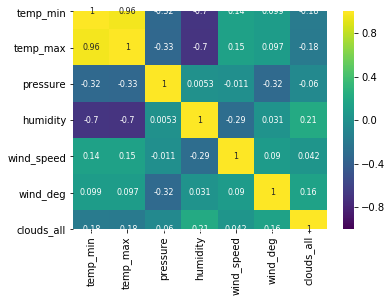

In [58]:
#plotting significant correlation in one plot (heatmap)

corr = df_num.drop('temp', axis=1).corr()
sns.heatmap(corr[(corr >= 20) | (corr <= 35)],
           cmap='viridis', vmax=1.0, vmin=-1.0,
           annot=True, annot_kws={"size": 8}, square=True);

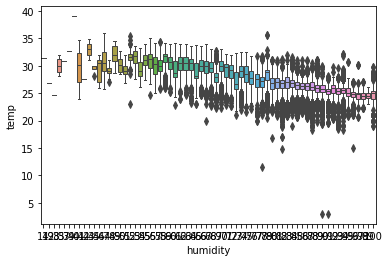

In [59]:
#box-plot (categorical-variable)
box1 = sns.boxplot(x='humidity', y='temp', linewidth =1, data=df)